In [1]:
!pip install sentence_transformers hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 54.8 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Obtaining dependency information for cython<3,>=0.27 from https://files.pythonhosted.org/packages/5b/b7/6e35bbbf253ff6c383eec57baab1c6814107b2b9caf26b10e9c25014bb1e/Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.w

In [2]:
import dask.bag as db #dask 
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sentence_transformers import SentenceTransformer
import hdbscan
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import logging # mainly use to hide or supress deprecation warnings

logging.captureWarnings(True)


pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 150

loaded_data = db.read_text('/kaggle/input/science-lit/arxiv-snapshot.json').map(json.loads)

#Load data extracted from the Arxiv's website
with open('/kaggle/input/taxonomy/general_topics.txt') as f:
    lines = f.readlines()

#Check first 10 lines of the data loaded to understand the patterns and structure present. 
print(*lines[:5], sep='\n')

#Define categories and the codes used by the original Arxiv dataset to represent these categories.
categories = {
    'computer science' : 'cs',
    'economics' : 'econ',
    'electrical engineering and system science' : 'eess',
    'mathematics' : 'math',
    'physics - astrophysics' : 'astro-ph',
    'physics - condensed matter' : 'cond-mat',
    'physics - general relativity and quantum cosmology' : 'gr-qc',
    'physics - high energy physics - experiment' : 'hep-ex',
    'high energy physics - lattice' : 'hep-lat',
    'high energy physics - phenomenology' : 'hep-ph',
    'high energy physics - theory' : 'hep-th',
    'mathematical physics' : 'math-ph',
    'physics - nonlinear sciences' : 'nlin',
    'physics - nuclear theory' : 'nucl-th',
    'physics - nuclear experiment' : 'nucl-ex', 
    'physics' : 'physics',
    'quantum physics' : 'quant-ph',
    'quantitative biology' : 'q-bio',
    'quantitative finance' : 'q-fin',
    'statistics' : 'stat',
    }

#Define function to structure the new loaded data (lines) from the ArXiv Website
def process_text(text):
    cleaned_list = []
    for l in text:
        if "\n" in l:
            l =  re.sub("\n", "", l)
        cleaned_list.append(l)

    pre_categories = cleaned_list[::2]
    categories_descriptions = cleaned_list[1::2]
    cleaned_list = []

    for i, v in enumerate(pre_categories):
        topic_start = v.find('(')
        topic_end = v.find(')')
        sub_category = v[topic_start+1:topic_end].strip().lower()
        category  = (v[:topic_start]).strip().lower()
        if '.' in category:
            main_category = category[:(category.find('.'))].lower()
        else:
            main_category = category.lower()

        for k, value in categories.items():
            if value == main_category:
                main_category = k.lower()
        
        categories_description = categories_descriptions[i].strip()
        if categories_description[-1] != '.':
            categories_description = categories_description + '.'

        # (cs.ai, computer science, artificial intelligence, descripcion) Example of new data format
        new_features = (category, main_category, sub_category, categories_description)
        cleaned_list.append(new_features)
       
    return cleaned_list

cleaned_new_data = process_text(lines)

#These tuples will be used to match each category's acronym and generate newly proposed features.
print(*cleaned_new_data[:5], sep='\n')



cs.AI (Artificial Intelligence)

This category covers all areas of AI except Vision, Robotics, Machine Learning, Multiagent Systems, and Computation and Language (Natural Language Processing), which have separate subject areas. In particular, includes Expert Systems, Theorem Proving (although this may overlap with Logic in Computer Science), Knowledge Representation, Planning, and Uncertainty in AI. 

cs.AR (Hardware Architecture)

This category covers systems organization and hardware architecture  

cs.CC (Computational Complexity)

('cs.ai', 'computer science', 'artificial intelligence', 'This category covers all areas of AI except Vision, Robotics, Machine Learning, Multiagent Systems, and Computation and Language (Natural Language Processing), which have separate subject areas. In particular, includes Expert Systems, Theorem Proving (although this may overlap with Logic in Computer Science), Knowledge Representation, Planning, and Uncertainty in AI.')
('cs.ar', 'computer science',

In [3]:

# Define a function that returns the latest year the paper was either published or updated
def get_last(x):
    get_latest_version = int((x['versions'][-1]['created']).split(' ')[3])
    get_latest_update = int((x['update_date']).split('-')[0])
    last_date = max(get_latest_version, get_latest_update)
    return last_date

# Define a function that returns only the relevant attributes
def trim_attributes(x):
    return {
        'id': x['id'],
        'authors': x['authors'],
        'title': x['title'],
        'category': x['categories'].split(' '),
        'abstract': x['abstract'],
        'versions': x['versions'],
        'update_date': x['update_date'],
    }

# Load data
loaded_data = db.read_text('/kaggle/input/science-lit/arxiv-snapshot.json').map(json.loads)

# Filter all articles that have remained relevant or mostly investigated for at least the past 5 years (since 2020)
filtered_data = loaded_data.filter(lambda x: get_last(x) > 2021)

# Sample 20% of the filtered data
sampled_data = filtered_data.random_sample(0.1)

# Map trimmed attributes to the sampled data
sampled_trimmed_data = sampled_data.map(trim_attributes)

# Convert the sampled and trimmed data to a pandas DataFrame
df = pd.DataFrame(sampled_trimmed_data.compute())

# Check DataFrame
print(df.head())
print(df.shape)
print(df.info())
print(df['category'].isnull().sum())


          id                                    authors  \
0  0705.1155                           Kerry M. Soileau   
1  0705.1600                             Anirban Pathak   
2  0706.0357                            Hisanobu Shinya   
3  0706.0725  Daniel Birmajer, Juan Gil, Michael Weiner   
4  0706.3282                                  Tao Zhang   

                                                                                                                                                   title  \
0                                                                                              State Vector Determination By A Single Tracking Satellite   
1                                                                     A mathematical criterion for single photon sources used in quantum\n  cryptography   
2  A certain continuity property of the residues of the poles of $\sum_{n\n  \geq 1} \Lambda(n) e^{-2 \pi i q n } n^{-s}$ with respect to $q \in\n  \...   
3                    

In [4]:
#Define function to generate new features
def category_extraction(x):
    new_category = []
    for i in x:
        i = i.lower()
        for tup in cleaned_new_data:
            if i == tup[0]:
                new_category.append('"' + tup[1] + '"') #IMPORT TO ADD QUOTES TO THE NEW CATEGORY, OTHERWISE IS IT GOING TO BE HARD TO PERFORM EDA
                break
            elif i in tup[0]:
                new_category.append('"' + tup[1] + '"')
                break
    new_category = list(set(new_category))
    return new_category 

def subcategory_extraction(x):
    new_subcategory = []
    for i in x:
        i = i.lower()
        for tup in cleaned_new_data:
            if i == tup[0]:
                new_subcategory.append('"' + tup[2] + '"')
                break
            elif i in tup[0]:
                new_subcategory.append('"' + tup[2] + '"')
                break
    new_subcategory = list(set(new_subcategory))
    return new_subcategory 

def description_extraction(x):
    new_description = []
    for i in x:
        i = i.lower()
        for tup in cleaned_new_data:
            if i == tup[0] and tup[3] != 'Description coming soon.':
                new_description.append(tup[3])
                break
            elif i in tup[0] and tup[3] != 'Description coming soon.':
                new_description.append(tup[3])
                break
    new_description = list(set(new_description))
    if len(new_description) > 1:
        new_description = ' Also, '.join(new_description)
    elif len(new_description) == 0:
        new_description = None
    else:
        new_description = new_description[0]

    return new_description 

def last_creation_date(x):
    # Check if x is a list and has elements
    if isinstance(x, list) and x:
        # Extract the last creation date from the versions list
        last_date_str = x[-1]['created']
        # Try different date formats to parse the date
        for fmt in ("%d %b %Y", "%Y-%m-%d", "%b %d, %Y"):
            try:
                return pd.to_datetime(last_date_str, format=fmt)
            except ValueError:
                continue
    return pd.NaT  # Return Not-a-Time for unparseable or empty dates


In [5]:
# Generate new features by traforming the old category attribute and filter data
df['new_category'] = df['category'].apply(lambda x: category_extraction(x=x))
df['sub_category'] = df['category'].apply(lambda x: subcategory_extraction(x=x))
df['description'] = df['category'].apply(lambda x: description_extraction(x=x))
df['update_date'] = pd.to_datetime(df['update_date'])
df['created_date'] = df['versions'].apply(last_creation_date)
df = df.reindex(columns=['id', 'title', 'authors', 'category', 'new_category', 'sub_category', 'created_date', 'update_date', 'description', 'abstract', 'versions'])


In [6]:
pd.options.display.max_rows = 1000
df.head()

,id,title,authors,category,new_category,sub_category,created_date,update_date,description,abstract,versions
0,0705.1155,State Vector Determination By A Single Tracking Satellite,Kerry M. Soileau,[astro-ph],"[""physics - astrophysics""]","[""cosmology and nongalactic astrophysics""]",NaT,2022-08-29,"This category includes phenomenology of early universe, cosmic microwave background, cosmological parameters, primordial element abundances, extra...","Using only a single tracking satellite capable of only range measurements to\nan orbiting object in an unknown Keplerian orbit, it is theoretica...","[{'version': 'v1', 'created': 'Tue, 8 May 2007 19:35:37 GMT'}, {'version': 'v2', 'created': 'Fri, 26 Aug 2022 14:22:37 GMT'}]"
1,0705.1600,A mathematical criterion for single photon sources used in quantum\n cryptography,Anirban Pathak,[quant-ph],"[""quantum physics""]","[""quantum physics""]",NaT,2022-06-10,None,"A single photon source (SPS) is very important for quantum computation. In\nparticular, it is essential for secured quantum cryptography. But th...","[{'version': 'v1', 'created': 'Fri, 11 May 2007 08:12:07 GMT'}]"
2,0706.0357,A certain continuity property of the residues of the poles of $\sum_{n\n \geq 1} \Lambda(n) e^{-2 \pi i q n } n^{-s}$ with respect to $q \in\n \...,Hisanobu Shinya,[math.GM],"[""mathematics""]","[""general mathematics""]",NaT,2023-11-21,"This category includes mathematical material of general interest, topics not covered elsewhere.",The purpose of this article is to present some result which may characterize\nnontrivial zeros of the Riemann zeta-function off the critical lin...,"[{'version': 'v1', 'created': 'Mon, 4 Jun 2007 08:48:54 GMT'}, {'version': 'v10', 'created': 'Mon, 12 Jul 2010 02:01:53 GMT'}, {'version': 'v11', ..."
3,0706.0725,Factorization of quadratic polynomials in the ring of formal power\n series over Z,"Daniel Birmajer, Juan Gil, Michael Weiner","[math.AC, math.GM, math.NT, math.RA]","[""mathematics""]","[""general mathematics"", ""number theory"", ""rings and algebras"", ""commutative algebra""]",NaT,2023-10-24,"This category includes prime numbers, diophantine equations, analytic number theory, algebraic number theory, arithmetic geometry, Galois theory. ...",We establish necessary and sufficient conditions for a quadratic polynomial\nto be irreducible in the ring $Z[[x]]$ of formal power series with ...,"[{'version': 'v1', 'created': 'Tue, 5 Jun 2007 19:42:22 GMT'}, {'version': 'v2', 'created': 'Sun, 22 Oct 2023 05:42:29 GMT'}]"
4,0706.3282,Braided Hom-Lie bialgebras,Tao Zhang,"[math.QA, math.RA]","[""mathematics""]","[""quantum algebra"", ""rings and algebras""]",NaT,2022-03-15,"This category includes non-commutative rings and algebras, non-associative algebras, universal algebra and lattice theory, linear algebra, semigro...","We introduce the new concept of braided Hom-Lie bialgebras which is a\ngeneralization of Sommerh\""{a}user-Majid's braided Lie bialgebras and Yau...","[{'version': 'v1', 'created': 'Fri, 22 Jun 2007 08:45:12 GMT'}, {'version': 'v10', 'created': 'Mon, 14 Mar 2022 05:52:21 GMT'}, {'version': 'v2', ..."


In [7]:
#Save filtered and cleaned data into a csv filed
df.to_csv('filtered_arxiv_db.csv', index = False)

In [8]:
from sentence_transformers import SentenceTransformer
# Embedding with SentenceTransformer
model = SentenceTransformer('allenai-specter')
corpus_embeddings = model.encode(df['abstract'].tolist(), show_progress_bar=True)

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.71k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/462k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/331 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/1490 [00:00<?, ?it/s]

In [9]:
# UMAP for dimensionality reduction
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine').fit_transform(corpus_embeddings)

In [10]:
# HDBSCAN for clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=200, metric='euclidean', cluster_selection_method='eom')
df['hdbscan_cluster'] = clusterer.fit_predict(umap_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

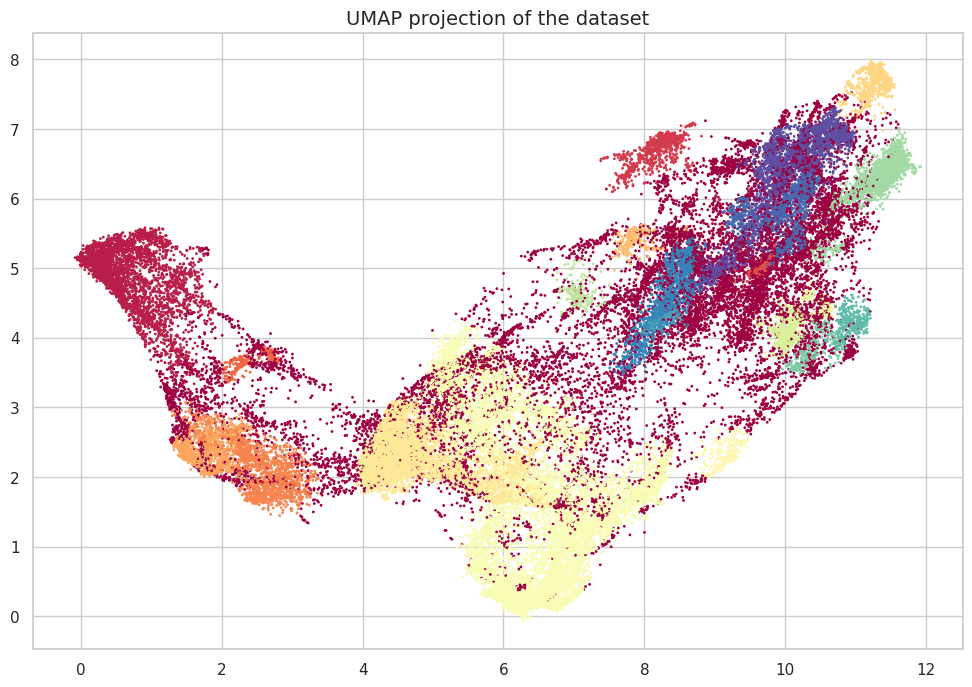

In [11]:
# Visualization
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=df['hdbscan_cluster'], s=1, cmap='Spectral')
plt.title('UMAP projection of the dataset', fontsize=14)
plt.show()

In [12]:
# Save DataFrame to CSV
df.to_csv('clustered_arxiv_db.csv', index=False)